# Support Vector Machine Classifier

# Setup
Let us import the required modules.

In [1]:
import time
import pandas as pd
import seaborn as sns

from loguru import logger
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import src.utilities.data_split as ds
import src.utilities.evaluation as eva
import src.utilities.model_selection as ms

## Load Data
Note that the dataset is already split into Train-Test sets.

In [2]:
data_split = ds.TrainTestSplit.from_csv_directory(dir_path="../data")

In [3]:
data_split.x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 3

In [4]:
data_split.y_train.shape

(60000,)

## Tuning Discriminative Classifiers: SVM

Use a smaller dataset to reduce the workload of GridSearchCV

<AxesSubplot:ylabel='count'>

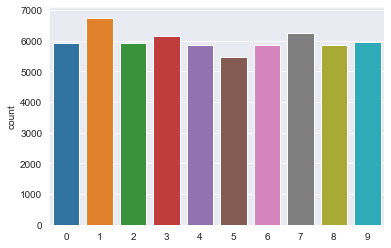

In [5]:
sns.countplot(x=data_split.y_train)

In [6]:
x_data_small, y_data_small = ds.get_train_subset(x_train=data_split.x_train, y_train=data_split.y_train, size=5000)

<AxesSubplot:xlabel='Number', ylabel='count'>

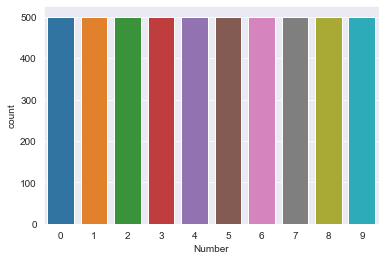

In [7]:
sns.countplot(x=y_data_small)

In [8]:
x_data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 39939 to 47235
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64

In [9]:
y_data_small.shape

(5000,)

In [10]:
y_data_small

39939    0
5818     0
4278     0
21580    0
39547    0
        ..
52559    9
44643    9
43043    9
16834    9
47235    9
Name: Number, Length: 5000, dtype: int64

## SVM using Linear kernel
Note that LinearSVC is another implementation of Support Vector Classification for the case of a linear kernel

In [11]:
# automatic parameters tuning
svcclsf_lin=SVC(random_state=28)
properties_lin={
    "C": [0.01,0.05,0.1,0.5,1,10,100,1000], # soft to hard margin
    "kernel": ["linear"]
}

tuned_svcclsf_lin = ms.model_selector(estimator=svcclsf_lin,properties=properties_lin,scoring="accuracy",cv=10,verbose=5,jobs=4,
                                       x_train=x_data_small,y_train=y_data_small)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


2022-12-27 04:16:42.650 | INFO     | src.utilities.model_selection:model_selector:26 - --- 671.8590168952942 seconds ---


In [12]:
# save results
ms.save_model(model=tuned_svcclsf_lin, model_name="svc_linear_tuning_results")

In [51]:
# to load previously saved results
tuned_svcclsf_lin = ms.load_model("svc_linear_tuning_results")

In [13]:
logger.info(tuned_svcclsf_lin.cv_results_)
tuned_svcclsf_lin_results = pd.DataFrame( tuned_svcclsf_lin.cv_results_ )

2022-12-27 04:16:42.856 | INFO     | __main__:<module>:1 - {'mean_fit_time': array([11.82199533,  8.68087153, 11.90555325, 12.18719769, 12.13478923,
       11.81433802, 11.43357844, 11.52242527]), 'std_fit_time': array([0.56495356, 0.9350445 , 0.44438221, 0.38743029, 0.33056018,
       0.29137036, 0.37221101, 0.30188902]), 'mean_score_time': array([2.26593993, 1.73268313, 2.20862529, 2.29308171, 2.17528174,
       2.03685091, 2.10151501, 2.13136485]), 'std_score_time': array([0.31302549, 0.33800897, 0.10694836, 0.0686185 , 0.0694816 ,
       0.10803565, 0.12655643, 0.10411209]), 'param_C': masked_array(data=[0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'linear', 'linear', 'linear', 'linear',
                   'linear', 'linear', 'linear'],
             mask=[False, False, False, False, False, False, False, False],
      

In [53]:
tuned_svcclsf_lin_results[["params","mean_test_score","mean_train_score"]]

,params,mean_test_score,mean_train_score
0,"{'C': 0.01, 'kernel': 'linear'}",0.9140,0.935378
1,"{'C': 0.05, 'kernel': 'linear'}",0.9214,0.966044
2,"{'C': 0.1, 'kernel': 'linear'}",0.9182,0.980111
3,"{'C': 0.5, 'kernel': 'linear'}",0.9074,0.998800
4,"{'C': 1, 'kernel': 'linear'}",0.9062,1.000000
5,"{'C': 10, 'kernel': 'linear'}",0.9062,1.000000
6,"{'C': 100, 'kernel': 'linear'}",0.9062,1.000000
7,"{'C': 1000, 'kernel': 'linear'}",0.9062,1.000000


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

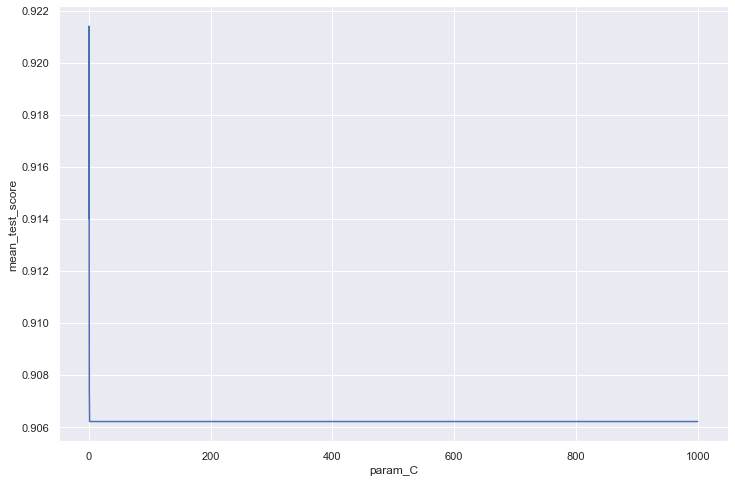

In [15]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_lin_results, x="param_C", y="mean_test_score")

In [52]:
print(tuned_svcclsf_lin.best_estimator_)
print(tuned_svcclsf_lin.best_score_)

SVC(C=0.05, kernel='linear', random_state=28)
0.9214


In [17]:
test_acc = accuracy_score(y_true = data_split.y_train,
                    y_pred = tuned_svcclsf_lin.predict(data_split.x_train))
print("Train Accuracy Score on original dataset: {}".format(test_acc) )

Train Accuracy Score on original dataset: 0.9260666666666667


In [18]:
# best parameters from automatic parameters tuning
start_time = time.time()
svc_lin_clsf = SVC(**tuned_svcclsf_lin.best_params_)
svc_lin_clsf.fit(data_split.x_train, data_split.y_train)
logger.info("Training: - %s seconds -" % (time.time() - start_time))

[CV 2/10] END C=0.01, kernel=linear;, score=(train=0.936, test=0.906) total time=  14.1s
[CV 8/10] END C=0.01, kernel=linear;, score=(train=0.934, test=0.918) total time=  14.5s
[CV 2/10] END C=0.05, kernel=linear;, score=(train=0.965, test=0.934) total time=  10.1s
[CV 3/10] END C=0.05, kernel=linear;, score=(train=0.967, test=0.916) total time=  12.0s
[CV 8/10] END C=0.05, kernel=linear;, score=(train=0.966, test=0.928) total time=   9.2s
[CV 2/10] END C=0.1, kernel=linear;, score=(train=0.978, test=0.932) total time=  14.0s
[CV 6/10] END C=0.1, kernel=linear;, score=(train=0.980, test=0.914) total time=  14.3s
[CV 9/10] END C=0.1, kernel=linear;, score=(train=0.979, test=0.936) total time=  14.5s
[CV 3/10] END C=0.5, kernel=linear;, score=(train=0.999, test=0.892) total time=  15.3s
[CV 8/10] END C=0.5, kernel=linear;, score=(train=0.998, test=0.908) total time=  14.2s
[CV 2/10] END C=1, kernel=linear;, score=(train=1.000, test=0.922) total time=  14.3s
[CV 6/10] END C=1, kernel=lin

SVC(C=0.05, kernel='linear')

# Performance

In [19]:
svc_lin_train_pred = svc_lin_clsf.predict(data_split.x_train)
svc_lin_train_eval = eva.Evaluation(y_true=data_split.y_train, y_pred=svc_lin_train_pred)

In [ ]:
start_time = time.time()
svc_lin_test_pred = svc_lin_clsf.predict(data_split.x_test)
logger.info("Prediction: - %s seconds -" % (time.time() - start_time))
svc_lin_test_eval = eva.Evaluation(y_true=data_split.y_test, y_pred=svc_lin_test_pred)

In [20]:
print("Training:")
svc_lin_train_eval.acc_eval()
print("Testing:")
svc_lin_test_eval.acc_eval()

Training:
-----Model Evaluations:-----
Accuracy score: 0.9557166666666667
Testing:
-----Model Evaluations:-----
Accuracy score: 0.9407


In [21]:
# save the model and evaluations
svc_lin_model = eva.EvaluatedModel(svc_lin_clsf, "svclinear", train_eval=svc_lin_train_eval, test_eval=svc_lin_test_eval)
svc_lin_model.save_evaluation()

In [27]:
# load the previously saved model and evaluations
# svc_lin_model = eva.EvaluatedModel.load_evaluation("svclinear")

### Confusion Matrix

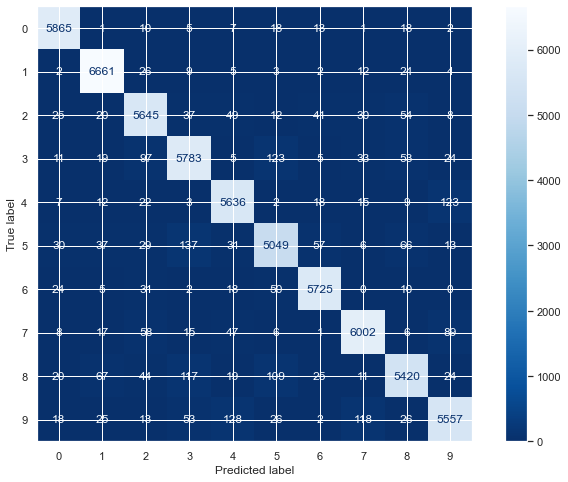

In [22]:
svc_lin_model.train_eval.conf_mat()

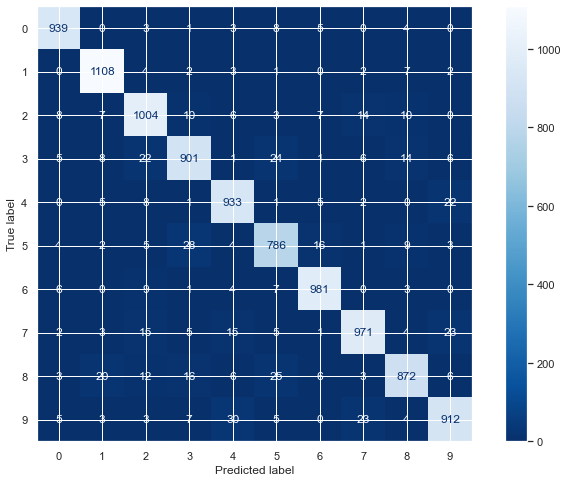

In [23]:
svc_lin_model.test_eval.conf_mat()

## SVM using Polynomial of degree 2 kernel

In [24]:
# automatic parameters tuning
svcclsf_pol=SVC(random_state=28)
properties_pol={
    "C": [0.01,0.05,0.1,0.5,1,10,100,1000], # soft to hard margin
    "kernel": ["poly"],
    "degree": [2],
    "gamma": ["auto",0.1,1]
}

tuned_svcclsf_pol = ms.model_selector(estimator=svcclsf_pol,properties=properties_pol,scoring="accuracy",cv=10,verbose=5,jobs=4,
                                       x_train=x_data_small,y_train=y_data_small)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


2022-12-27 05:07:24.648 | INFO     | src.utilities.model_selection:model_selector:26 - --- 1223.4280741214752 seconds ---


In [25]:
# # save results
ms.save_model(model=tuned_svcclsf_pol, model_name="svc_polynomial_tuning_results")

In [26]:
# to load previously saved results
tuned_svcclsf_pol = ms.load_model("svc_polynomial_tuning_results")

In [27]:
logger.info(tuned_svcclsf_pol.cv_results_)
tuned_svcclsf_pol_results = pd.DataFrame( tuned_svcclsf_pol.cv_results_ )

2022-12-27 05:07:24.801 | INFO     | __main__:<module>:1 - {'mean_fit_time': array([49.04833984, 10.5066994 ,  7.8626107 , 44.2571677 ,  6.62637334,
        5.74379909, 30.77329595,  3.7376955 ,  3.61435018, 19.60069354,
        3.05660152,  2.95731485, 15.94592769,  3.04264102,  3.01380506,
        7.22396894,  2.96385846,  2.95061166,  3.59501448,  2.96150031,
        3.0498256 ,  3.0561584 ,  2.97313254,  2.95912497]), 'std_fit_time': array([0.73561249, 0.20860876, 0.22572661, 3.73292049, 0.45102757,
       0.15398948, 4.03934199, 0.32584582, 0.18429509, 1.26436944,
       0.13138504, 0.06705536, 0.1731397 , 0.1735914 , 0.13242508,
       0.18839318, 0.04930323, 0.05232726, 0.18877276, 0.03249949,
       0.14695848, 0.15589749, 0.1015193 , 0.05352347]), 'mean_score_time': array([3.48145664, 1.51942616, 1.23083274, 3.24958413, 1.01898768,
       0.91433275, 2.10200627, 0.63124623, 0.58098512, 1.54709213,
       0.47709203, 0.46524794, 1.64613497, 0.46243844, 0.45039084,
       0.8923

In [28]:
tuned_svcclsf_pol_results[["params","mean_test_score","mean_train_score"]]

,params,mean_test_score,mean_train_score
0,"{'C': 0.01, 'degree': 2, 'gamma': 'auto', 'ker...",0.3788,0.385489
1,"{'C': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel...",0.9322,0.966778
2,"{'C': 0.01, 'degree': 2, 'gamma': 1, 'kernel':...",0.9464,1.000000
3,"{'C': 0.05, 'degree': 2, 'gamma': 'auto', 'ker...",0.3788,0.385489
4,"{'C': 0.05, 'degree': 2, 'gamma': 0.1, 'kernel...",0.9444,0.997400
5,"{'C': 0.05, 'degree': 2, 'gamma': 1, 'kernel':...",0.9464,1.000000
6,"{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kern...",0.3788,0.385489
7,"{'C': 0.1, 'degree': 2, 'gamma': 0.1, 'kernel'...",0.9464,1.000000
8,"{'C': 0.1, 'degree': 2, 'gamma': 1, 'kernel': ...",0.9464,1.000000
9,"{'C': 0.5, 'degree': 2, 'gamma': 'auto', 'kern...",0.5150,0.522244


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

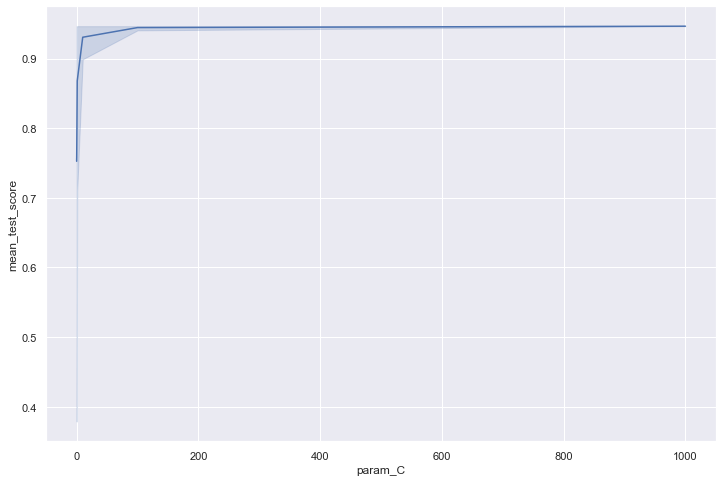

In [29]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_pol_results, x="param_C", y="mean_test_score")

In [30]:
print(tuned_svcclsf_pol.best_estimator_)
print(tuned_svcclsf_pol.best_score_)

logger.info("Best Score: {:.3f}".format(tuned_svcclsf_pol.best_score_))
logger.info("Best Params: ", tuned_svcclsf_pol.best_params_)

2022-12-27 05:07:25.320 | INFO     | __main__:<module>:4 - Best Score: 0.946
2022-12-27 05:07:25.321 | INFO     | __main__:<module>:5 - Best Params: 


SVC(C=0.01, degree=2, gamma=1, kernel='poly', random_state=28)
0.9464


In [31]:
test_acc = accuracy_score(y_true = data_split.y_train,
                    y_pred = tuned_svcclsf_pol.predict(data_split.x_train))
print("Train accuracy Score on original dataset: {}".format(test_acc) )

Train accuracy Score on original dataset: 0.9568333333333333


In [32]:
# best parameters from automatic parameters tuning
start_time = time.time()
svc_pol_clsf = SVC(**tuned_svcclsf_pol.best_params_)
svc_pol_clsf.fit(data_split.x_train, data_split.y_train)
logger.info("Training: - %s seconds -" % (time.time() - start_time))

SVC(C=0.01, degree=2, gamma=1, kernel='poly')

# Performance

In [ ]:
svc_pol_train_pred = svc_pol_clsf.predict(data_split.x_train)
svc_pol_train_eval = eva.Evaluation(y_true=data_split.y_train, y_pred=svc_pol_train_pred)

In [ ]:
start_time = time.time()
svc_pol_test_pred = svc_pol_clsf.predict(data_split.x_test)
logger.info("Prediction: - %s seconds -" % (time.time() - start_time))
svc_pol_test_eval = eva.Evaluation(y_true=data_split.y_test, y_pred=svc_pol_test_pred)

In [34]:
print("Training:")
svc_pol_train_eval.acc_eval()
print("Testing:")
svc_pol_test_eval.acc_eval()

Training:
-----Model Evaluations:-----
Accuracy score: 1.0
Testing:
-----Model Evaluations:-----
Accuracy score: 0.9801


In [35]:
# save the model and evaluations
svc_pol_model = eva.EvaluatedModel(svc_pol_clsf, "svcpolynomial", train_eval=svc_pol_train_eval, test_eval=svc_pol_test_eval)
svc_pol_model.save_evaluation()

In [43]:
# load the previously saved model and evaluations
# svc_pol_model = eva.EvaluatedModel.load_evaluation("svcpolynomial")

### Confusion Matrix

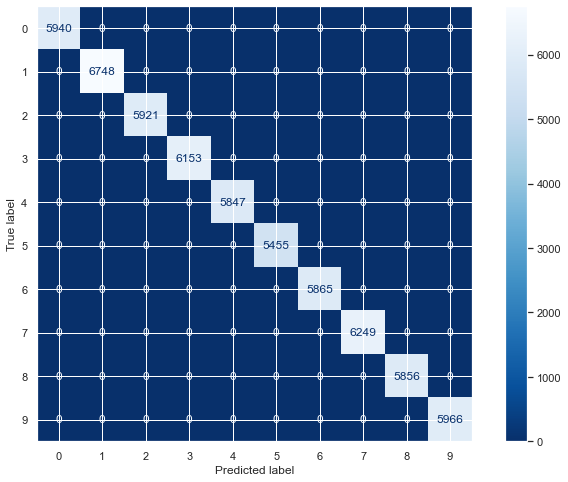

In [36]:
svc_pol_model.train_eval.conf_mat()

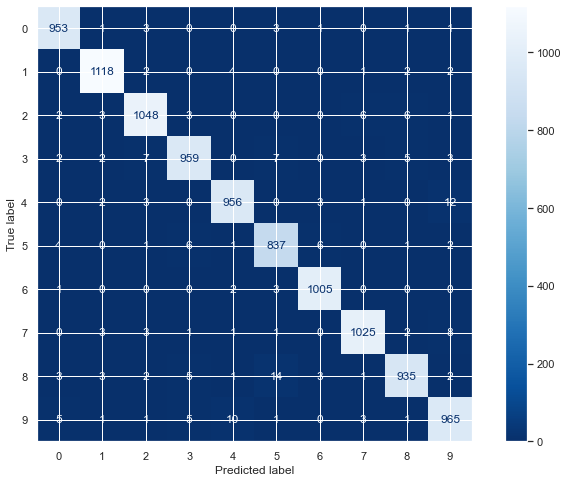

In [37]:
svc_pol_model.test_eval.conf_mat()

## SVM using RBF kernel

In [38]:
# automatic parameters tuning
svcclsf_rbf=SVC(random_state=28)
properties_rbf={
    "C": [0.01,0.05,0.1,0.5,1,10,100,1000], # soft to hard margin
    "kernel": ["rbf"],
    "gamma": ["auto",0.1,1]
}

tuned_svcclsf_rbf = ms.model_selector(estimator=svcclsf_rbf,properties=properties_rbf,scoring="accuracy",cv=10,verbose=5,jobs=4,
                                       x_train=x_data_small,y_train=y_data_small)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


2022-12-27 05:48:57.081 | INFO     | src.utilities.model_selection:model_selector:26 - --- 2142.5679848194122 seconds ---


In [39]:
# save results
ms.save_model(model=tuned_svcclsf_rbf, model_name="svc_rbf_tuning_results")

In [54]:
# to load previously saved results
tuned_svcclsf_rbf = ms.load_model("svc_rbf_tuning_results")

In [40]:
logger.info(tuned_svcclsf_rbf.cv_results_)
tuned_svcclsf_rbf_results = pd.DataFrame( tuned_svcclsf_rbf.cv_results_ )

2022-12-27 05:48:57.133 | INFO     | __main__:<module>:1 - {'mean_fit_time': array([20.16200025, 20.03066852, 20.16665211, 18.62467692, 19.76099782,
       19.77160082, 14.82324867, 18.75734594, 19.17091317,  6.8501605 ,
       17.47565   , 17.95972152,  5.0894841 , 19.19895315, 19.14317982,
        2.7698257 , 18.96183784, 18.6968359 ,  2.49168344, 19.49969909,
       19.43229873,  2.42780144, 18.7420733 , 18.59187193]), 'std_fit_time': array([0.15833687, 0.04028002, 0.15639389, 0.21891767, 0.13198126,
       0.12496039, 0.24754738, 0.09396987, 0.11598723, 0.40850699,
       0.2446515 , 0.08340013, 0.10667044, 0.17285506, 0.35611427,
       0.25958866, 0.11704655, 0.15151484, 0.24945044, 0.1079899 ,
       0.08955697, 0.19383526, 0.05510619, 0.23742892]), 'mean_score_time': array([2.29845355, 2.2431082 , 2.24798765, 2.23228834, 2.20889311,
       2.28576815, 2.12747488, 2.15380425, 2.20454292, 1.60808558,
       2.12440948, 2.20194371, 1.36386316, 2.05828714, 2.37646403,
       0.8426

In [55]:
tuned_svcclsf_rbf_results[["params","mean_test_score","mean_train_score"]]

,params,mean_test_score,mean_train_score
0,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.7202,0.728178
1,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}",0.3948,0.756111
2,"{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}",0.1096,1.000000
3,"{'C': 0.05, 'gamma': 'auto', 'kernel': 'rbf'}",0.7712,0.778622
4,"{'C': 0.05, 'gamma': 0.1, 'kernel': 'rbf'}",0.4050,0.765178
5,"{'C': 0.05, 'gamma': 1, 'kernel': 'rbf'}",0.1096,1.000000
6,"{'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}",0.8174,0.823200
7,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.4162,0.776889
8,"{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}",0.1096,1.000000
9,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.8864,0.897489


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

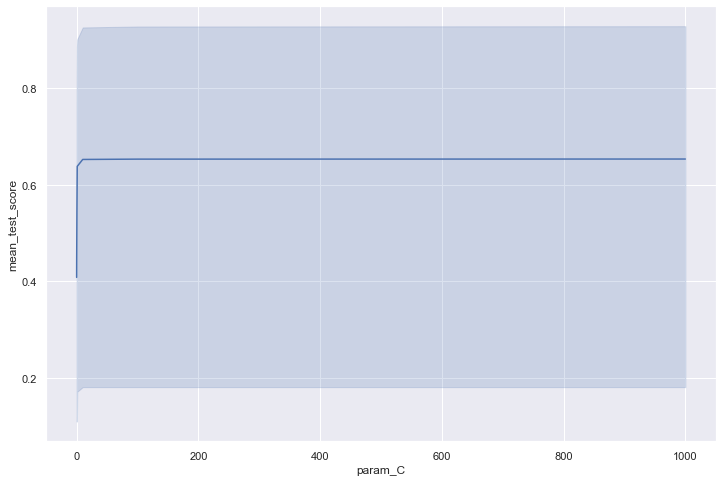

In [42]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_rbf_results, x="param_C", y="mean_test_score")

In [56]:
print(tuned_svcclsf_rbf.best_estimator_)
print(tuned_svcclsf_rbf.best_score_)

logger.info("Best Score: {:.3f}".format(tuned_svcclsf_rbf.best_score_))
logger.info("Best Params: ", tuned_svcclsf_rbf.best_params_)

2022-12-27 13:59:45.694 | INFO     | __main__:<module>:4 - Best Score: 0.929
2022-12-27 13:59:45.696 | INFO     | __main__:<module>:5 - Best Params: 


SVC(C=1000, gamma='auto', random_state=28)
0.9286000000000001


In [44]:
test_acc = accuracy_score(y_true = data_split.y_train,
                    y_pred = tuned_svcclsf_rbf.predict(data_split.x_train))
print("Train accuracy Score on original dataset: {}".format(test_acc) )

Train accuracy Score on original dataset: 0.9377166666666666


In [45]:
# best parameters from automatic parameters tuning
start_time = time.time()
svc_rbf_clsf = SVC(**tuned_svcclsf_rbf.best_params_)
svc_rbf_clsf.fit(data_split.x_train, data_split.y_train)
logger.info("Training: - %s seconds -" % (time.time() - start_time))

SVC(C=1000, gamma='auto')

# Performance

In [ ]:
svc_rbf_train_pred = svc_rbf_clsf.predict(data_split.x_train)
svc_rbf_train_eval = eva.Evaluation(y_true=data_split.y_train, y_pred=svc_rbf_train_pred)

In [ ]:
start_time = time.time()
svc_rbf_test_pred = svc_rbf_clsf.predict(data_split.x_test)
logger.info("Prediction: - %s seconds -" % (time.time() - start_time))
svc_rbf_test_eval = eva.Evaluation(y_true=data_split.y_test, y_pred=svc_rbf_test_pred)

In [47]:
print("Training:")
svc_rbf_train_eval.acc_eval()
print("Testing:")
svc_rbf_test_eval.acc_eval()

Training:
-----Model Evaluations:-----
Accuracy score: 0.9999666666666667
Testing:
-----Model Evaluations:-----
Accuracy score: 0.9726


In [48]:
# save the model and evaluations
svc_rbf_model = eva.EvaluatedModel(svc_rbf_clsf, "svcrbf", train_eval=svc_rbf_train_eval, test_eval=svc_rbf_test_eval)
svc_rbf_model.save_evaluation()

In [ ]:
# load the previously saved model and evaluations
# svc_rbf_model = eva.EvaluatedModel.load_evaluation("svcrbf")

### Confusion Matrix

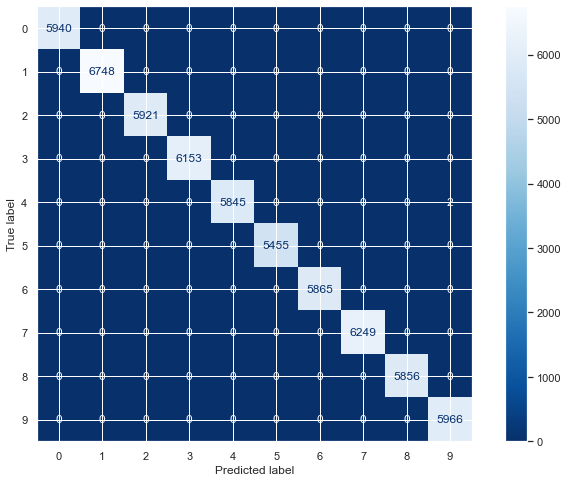

In [49]:
svc_rbf_model.train_eval.conf_mat()

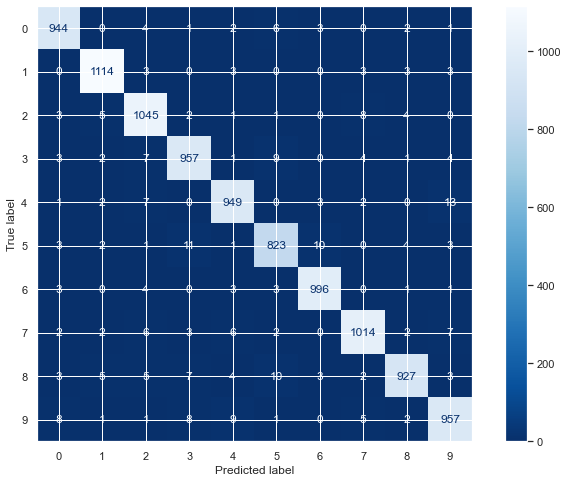

In [50]:
svc_rbf_model.test_eval.conf_mat()